# Training XGBoost – Last Dance

Train theo nhóm năm học **Y1..Y6** (không tách Y1 Sem1/Sem2). Target **Ratio** → post-processing → **pred_tc_final**. **Y1**: một model Tweedie (features riêng). **Y2–Y6**: giống train_by_year — 1 model/năm, features FEAT_COLS_Y2PLUS (Load_Ratio, Prev_CPA, Prev_GPA, History_Completion_Rate, History_Fail_Credits, Semester_No, Gap_Score, is_Covid, TOHOP_GROUP, PTXT_GROUP), không chia A/B. Đánh giá **MAE, RMSE** trên pred_tc_final. Explainable AI: Feature Importance, SHAP, LIME.

**NGUYÊN TẮC:** Không dùng đường dẫn tuyệt đối; chạy tuần tự (Run All); seed cố định.

## 1. Import và thiết lập (Seed, đường dẫn)

In [ ]:
# Dependencies – chạy nếu cần (Colab / local):
# !pip install xgboost scikit-learn pandas numpy matplotlib shap lime
# Hoặc: !pip install -r requirements.txt

import os
import random
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import joblib
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import matplotlib.pyplot as plt

try:
    import shap
except ImportError:
    shap = None
    print("Chạy: pip install shap")
try:
    from lime.lime_tabular import LimeTabularExplainer
except ImportError:
    LimeTabularExplainer = None
    print("Chạy: pip install lime")

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

# ========== CỐ ĐỊNH HẠT GIỐNG (bắt buộc) ==========
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
try:
    import tensorflow as tf
    tf.random.set_seed(SEED)
except Exception:
    pass
try:
    import torch
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
except Exception:
    pass

# ========== ĐƯỜNG DẪN – NO HARD-CODING ==========
try:
    IN_COLAB = "google.colab" in str(get_ipython())
except NameError:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount("/content/drive")
    base_dir_env = os.environ.get("DATAFLOW_BASE_DIR", "/content/drive/MyDrive/DataFlow_TeamX")
    BASE_DIR = Path(base_dir_env).resolve()
else:
    base_dir_env = os.environ.get("DATAFLOW_BASE_DIR", ".")
    BASE_DIR = Path(base_dir_env).resolve()

DATA_DIR = BASE_DIR / "data"
OUT_DIR = BASE_DIR / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("BASE_DIR:", BASE_DIR)
print("DATA_DIR:", DATA_DIR)
print("SEED:", SEED)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/apple/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/apple/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/apple/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py", line 758, in start
    self.io_loop.start()
 

AttributeError: _ARRAY_API not found

ImportError: numpy.core._multiarray_umath failed to import

BASE_DIR: /Users/apple/Documents/flow/last_dance
DATA_DIR: /Users/apple/Documents/flow/last_dance/data
SEED: 42


## 2. Load dữ liệu Train/Valid theo nhóm (Y1..Y6)

In [56]:

DATA_DIR_STR = str(DATA_DIR)
TARGET_COL = "TC_HOANTHANH"
TARGET_RATIO = "Ratio"

# Load train files (train_year_1..6)
train_files = {}
for year in range(1, 7):
    path_train = os.path.join(DATA_DIR_STR, f"train_year_{year}.csv")
    if os.path.exists(path_train):
        train_files[f"Y{year}"] = pd.read_csv(path_train)
        print(f"✓ Loaded train_year_{year}: {train_files[f'Y{year}'].shape}")
    else:
        print(f"✗ Chưa tìm thấy train_year_{year}.csv")

# Load valid: tách riêng Y1 và Y2+ (feature Y1 khác Y2+)
FEATS_Y1 = ["Rank_In_Major", "Gap_Score", "TOHOP_GROUP", "PTXT_GROUP"]
valid_Y1_df = None
valid_Y2plus_df = None
if os.path.exists(os.path.join(DATA_DIR_STR, "valid_Y1_features.csv")):
    valid_Y1_df = pd.read_csv(os.path.join(DATA_DIR_STR, "valid_Y1_features.csv"))
    print(f"✓ Loaded valid_Y1_features: {valid_Y1_df.shape}")
else:
    print("✗ Chưa tìm thấy valid_Y1_features.csv")
if os.path.exists(os.path.join(DATA_DIR_STR, "valid_Y2plus_features.csv")):
    valid_Y2plus_df = pd.read_csv(os.path.join(DATA_DIR_STR, "valid_Y2plus_features.csv"))
    print(f"✓ Loaded valid_Y2plus_features: {valid_Y2plus_df.shape}")
else:
    print("✗ Chưa tìm thấy valid_Y2plus_features.csv")

# Load train feature files (train_Y1_features..train_Y6_features)
train_feature_files = {}
for year in range(1, 7):
    path_feat = os.path.join(DATA_DIR_STR, f"train_Y{year}_features.csv")
    if os.path.exists(path_feat):
        train_feature_files[f"Y{year}"] = pd.read_csv(path_feat)
        print(f"✓ Loaded train_Y{year}_features: {train_feature_files[f'Y{year}'].shape}")
    else:
        print(f"✗ Chưa tìm thấy train_Y{year}_features.csv")

# Ghép features + target thành train_data (cho từng nhóm)
train_data = {}
for key in list(train_files.keys()):
    if key not in train_feature_files:
        continue
    feat = train_feature_files[key].copy()
    year_df = train_files[key]
    if len(feat) != len(year_df):
        print(f"Cảnh báo {key}: số dòng features ({len(feat)}) != year ({len(year_df)})")
    if "MA_SO_SV" in feat.columns:
        feat = feat.drop(columns=["MA_SO_SV"])
    # Target: Ratio (0-1) cho training; y_tc cho đánh giá MAE/RMSE sau post-processing
    if TARGET_RATIO in year_df.columns:
        y_ratio = np.clip(pd.to_numeric(year_df[TARGET_RATIO], errors="coerce").fillna(0), 0, 1).values
    else:
        tc_dk = year_df["TC_DANGKY"].replace(0, np.nan)
        y_ratio = np.clip((year_df[TARGET_COL] / tc_dk).fillna(0), 0, 1).values
    train_data[key] = {"X": feat, "y": y_ratio, "y_tc": year_df[TARGET_COL].values, "year_df": year_df}

# valid_data: Y1 từ valid_Y1_features, Y2-Y6 từ valid_Y2plus_features (filter theo năm)
valid_data = {}
if valid_Y1_df is not None:
    feat_cols = [c for c in FEATS_Y1 if c in valid_Y1_df.columns]
    if feat_cols and "TC_DANGKY" in valid_Y1_df.columns and "TC_HOANTHANH" in valid_Y1_df.columns:
        feat = valid_Y1_df[feat_cols].copy()
        tc_dk = valid_Y1_df["TC_DANGKY"].replace(0, np.nan)
        y_ratio = np.clip((valid_Y1_df["TC_HOANTHANH"] / tc_dk).fillna(0), 0, 1).values
        y_tc = valid_Y1_df["TC_HOANTHANH"].values
        year_df = valid_Y1_df[["TC_DANGKY", "TC_HOANTHANH"]].copy()
        year_df[TARGET_COL] = year_df["TC_HOANTHANH"]
        valid_data["Y1"] = {"X": feat, "y": y_ratio, "y_tc": y_tc, "year_df": year_df}
if valid_Y2plus_df is not None and "Year_of_Study" in valid_Y2plus_df.columns:
    feat_cols_y2p = [c for c in ["Load_Ratio", "Prev_CPA", "Prev_GPA", "History_Completion_Rate", "History_Fail_Credits", "Semester_No", "Gap_Score", "is_Covid", "TOHOP_GROUP", "PTXT_GROUP"] if c in valid_Y2plus_df.columns]
    for yr in range(2, 7):
        sub = valid_Y2plus_df[valid_Y2plus_df["Year_of_Study"] == yr]
        if len(sub) == 0 or not feat_cols_y2p:
            continue
        feat = sub[feat_cols_y2p].copy()
        y_ratio = np.clip(pd.to_numeric(sub["Ratio"], errors="coerce").fillna(0), 0, 1).values
        y_tc = sub["TC_HOANTHANH"].values
        year_df = sub[["Ratio", "TC_HOANTHANH"]].copy()
        if "TC_DANGKY" in sub.columns:
            year_df["TC_DANGKY"] = sub["TC_DANGKY"].values
        else:
            year_df["TC_DANGKY"] = np.where(y_ratio > 0, np.round(sub["TC_HOANTHANH"].values / y_ratio).astype(float), 0)
        year_df[TARGET_COL] = year_df["TC_HOANTHANH"]
        valid_data[f"Y{yr}"] = {"X": feat, "y": y_ratio, "y_tc": y_tc, "year_df": year_df}
print(f"✓ valid_data: Y1 từ valid_Y1_features, Y2+ từ valid_Y2plus_features → {list(valid_data.keys())}")

print("\nTổng kết:")
print(f" - Train files: {len(train_files)}/6")
print(f" - Valid: valid_Y1_features + valid_Y2plus_features → valid_data {list(valid_data.keys())}")
print(f" - Train features: {len(train_feature_files)}/6")
print(f" - train_data (để train): {list(train_data.keys())}")
print(f" - valid_data (để đánh giá): {list(valid_data.keys())}")

✓ Loaded train_year_1: (25027, 19)
✓ Loaded train_year_2: (23154, 19)
✓ Loaded train_year_3: (20940, 19)


✓ Loaded train_year_4: (13848, 19)
✓ Loaded train_year_5: (6822, 19)
✓ Loaded train_year_6: (791, 19)
✓ Loaded valid_Y1_features: (3504, 7)
✓ Loaded valid_Y2plus_features: (11640, 15)
✓ Loaded train_Y1_features: (25027, 5)
✓ Loaded train_Y2_features: (23154, 11)
✓ Loaded train_Y3_features: (20940, 11)
✓ Loaded train_Y4_features: (13848, 11)
✓ Loaded train_Y5_features: (6822, 11)
✓ Loaded train_Y6_features: (791, 11)
✓ valid_data: Y1 từ valid_Y1_features, Y2+ từ valid_Y2plus_features → ['Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6']

Tổng kết:
 - Train files: 6/6
 - Valid: valid_Y1_features + valid_Y2plus_features → valid_data ['Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6']
 - Train features: 6/6
 - train_data (để train): ['Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6']
 - valid_data (để đánh giá): ['Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6']


## 2.2 Định nghĩa feature và hàm prepare_X cho Y2+ (giống train_by_year_predict.ipynb)

In [57]:
# === Định nghĩa feature cho Y2+ (giống train_by_year_predict.ipynb) ===

NUMERIC_FEATURES_Y2PLUS = [
    'Load_Ratio', 'Prev_CPA', 'Prev_GPA',
    'History_Completion_Rate', 'History_Fail_Credits',
    'Semester_No', 'Gap_Score', 'is_Covid'
]
CATEGORICAL_FEATURES_Y2PLUS = ['TOHOP_GROUP', 'PTXT_GROUP']
FEAT_COLS_Y2PLUS = NUMERIC_FEATURES_Y2PLUS + CATEGORICAL_FEATURES_Y2PLUS

def prepare_X_y2plus(df_feats: pd.DataFrame) -> pd.DataFrame:
    """
    Chuẩn hóa feature cho Y2+ giống train_by_year_predict.ipynb.
    Categorical: convert sang string, fillna("unknown")
    Numeric: convert sang numeric, fillna(0)
    """
    X = df_feats.copy()
    for c in CATEGORICAL_FEATURES_Y2PLUS:
        if c in X.columns:
            X[c] = X[c].astype(str).fillna("unknown")
    for c in NUMERIC_FEATURES_Y2PLUS:
        if c in X.columns:
            X[c] = pd.to_numeric(X[c], errors="coerce").fillna(0)
    # Chỉ giữ đúng FEAT_COLS_Y2PLUS (có thể thiếu cột nếu file không có)
    cols = [c for c in FEAT_COLS_Y2PLUS if c in X.columns]
    return X[cols]

print("Đã định nghĩa NUMERIC_FEATURES_Y2PLUS, CATEGORICAL_FEATURES_Y2PLUS, FEAT_COLS_Y2PLUS và prepare_X_y2plus.")

Đã định nghĩa NUMERIC_FEATURES_Y2PLUS, CATEGORICAL_FEATURES_Y2PLUS, FEAT_COLS_Y2PLUS và prepare_X_y2plus.


## 3.b Train model theo Year_of_Study cho Year 2+ (giống train_by_year_predict.ipynb)

In [58]:
# === Y2-Y6: Train theo Year_of_Study (giống train_by_year_predict.ipynb) ===

# Gộp toàn bộ train_data Y2-Y6 vào 1 DataFrame chung
frames_y2plus = []
for year in range(2, 7):
    key = f"Y{year}"
    if key not in train_data:
        continue
    X_raw = train_data[key]["X"].copy()
    year_df = train_data[key]["year_df"].copy()
    y_ratio = train_data[key]["y"]  # Ratio (0-1) - đã là numpy array
    
    # Chuẩn bị X_raw với prepare_X_y2plus
    X_prepared = prepare_X_y2plus(X_raw)
    
    # Gắn thêm các cột cần cho train/đánh giá
    df_year = X_prepared.copy()
    if "TC_DANGKY" in year_df.columns:
        df_year["TC_DANGKY"] = pd.to_numeric(year_df["TC_DANGKY"], errors="coerce").fillna(0).values
    if "TC_HOANTHANH" in year_df.columns:
        df_year["TC_HOANTHANH"] = pd.to_numeric(year_df["TC_HOANTHANH"], errors="coerce").fillna(0).values
    df_year["Ratio"] = y_ratio
    df_year["Year_of_Study"] = year
    frames_y2plus.append(df_year)

if not frames_y2plus:
    raise RuntimeError("Không có dữ liệu cho Year 2-6 trong train_data.")

train_y2plus = pd.concat(frames_y2plus, axis=0).reset_index(drop=True)
print(f"Train Y2+: {train_y2plus.shape}")

# Xác định cột feature: chỉ dùng FEAT_COLS_Y2PLUS (có thể thiếu một số cột)
drop_cols = {"Ratio", "TC_DANGKY", "TC_HOANTHANH", "Year_of_Study"}
feature_cols_y2plus = [c for c in FEAT_COLS_Y2PLUS if c in train_y2plus.columns and c not in drop_cols]
print(f"Số feature dùng cho Y2+: {len(feature_cols_y2plus)}")
print(f"Feature columns: {feature_cols_y2plus}")
missing_feats = [c for c in FEAT_COLS_Y2PLUS if c not in feature_cols_y2plus]
if missing_feats:
    print(f"Cảnh báo: Thiếu các feature: {missing_feats}")

# ColumnTransformer chung cho Y2-Y6 (chỉ dùng các feature có sẵn)
num_feats_available = [c for c in NUMERIC_FEATURES_Y2PLUS if c in feature_cols_y2plus]
cat_feats_available = [c for c in CATEGORICAL_FEATURES_Y2PLUS if c in feature_cols_y2plus]
transformers = []
if num_feats_available:
    transformers.append(("num", StandardScaler(), num_feats_available))
if cat_feats_available:
    transformers.append(("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_feats_available))
if not transformers:
    raise ValueError("Không có feature nào để train!")
preprocessor_y2plus = ColumnTransformer(transformers=transformers)

X_train_full_raw = train_y2plus[feature_cols_y2plus].copy()
for c in cat_feats_available:
    X_train_full_raw[c] = X_train_full_raw[c].astype(str).fillna("unknown")
preprocessor_y2plus.fit(X_train_full_raw)

# Train model theo Year_of_Study (2..6)
models_y2plus = {}
train_scores_y2plus = []

for year in sorted(train_y2plus["Year_of_Study"].unique()):
    sub = train_y2plus[train_y2plus["Year_of_Study"] == year].copy()
    if len(sub) < 50:
        print(f"Year {year}: quá ít sample ({len(sub)}), bỏ qua.")
        continue

    sub_feat = sub[feature_cols_y2plus].copy()
    for c in cat_feats_available:
        sub_feat[c] = sub_feat[c].astype(str).fillna("unknown")
    X_yr = preprocessor_y2plus.transform(sub_feat)
    y_ratio = sub["Ratio"].values

    model = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=1.0,
        random_state=42,
        n_jobs=-1,
    )
    model.fit(X_yr, y_ratio)
    models_y2plus[year] = model

    # Đánh giá train MAE trên TC_HOANTHANH (giống train_by_year_predict)
    if "TC_DANGKY" in sub.columns and "TC_HOANTHANH" in sub.columns:
        pred_tc = np.round(sub["TC_DANGKY"].values * np.clip(model.predict(X_yr), 0, 1))
        mae_yr = mean_absolute_error(sub["TC_HOANTHANH"].values, pred_tc)
        train_scores_y2plus.append(mae_yr)
        print(f"Year {year}: {len(sub)} samples, Train MAE: {mae_yr:.4f}")
    else:
        print(f"Year {year}: {len(sub)} samples (thiếu TC_DANGKY/TC_HOANTHANH để tính MAE)")

if train_scores_y2plus:
    print(f"Train MAE trung bình (Year 2+): {np.mean(train_scores_y2plus):.4f}")

# Không lưu .joblib ở đây — Y1 và Y2–Y6 đều được lưu đồng dạng ở cell cuối (xgb_model_Y1.joblib, preprocessor_Y1.joblib, xgb_model_Y2.joblib, ...) để predict load.

Train Y2+: (65555, 14)
Số feature dùng cho Y2+: 10
Feature columns: ['Load_Ratio', 'Prev_CPA', 'Prev_GPA', 'History_Completion_Rate', 'History_Fail_Credits', 'Semester_No', 'Gap_Score', 'is_Covid', 'TOHOP_GROUP', 'PTXT_GROUP']
Year 2: 23154 samples, Train MAE: 2.6398
Year 3: 20940 samples, Train MAE: 2.6876
Year 4: 13848 samples, Train MAE: 2.2389
Year 5: 6822 samples, Train MAE: 1.6332
Year 6: 791 samples, Train MAE: 1.3869
Train MAE trung bình (Year 2+): 2.1173


In [59]:
def apply_post_processing(df_pred):
    df = df_pred.copy()
    df["pred_rate"] = np.clip(df["pred_rate"], 0, 1)
    df["pred_tc"] = (df["pred_rate"] * df["TC_DANGKY"]).clip(lower=0)
    df["pred_tc"] = np.minimum(df["pred_tc"], df["TC_DANGKY"])
    if "Weighted_Completion_Rate" in df.columns:
        mask_mid = (df["TC_DANGKY"] >= 36) & (df["TC_DANGKY"] < 40) & (df["Weighted_Completion_Rate"] >= 0.65)
        if mask_mid.any():
            df.loc[mask_mid, "pred_tc"] = np.maximum(df.loc[mask_mid, "pred_tc"], 0.8 * df.loc[mask_mid, "TC_DANGKY"])
        mask_heavy = (df["TC_DANGKY"] >= 40) & (df["Weighted_Completion_Rate"] >= 0.7)
        if mask_heavy.any():
            df.loc[mask_heavy, "pred_tc"] = np.maximum(df.loc[mask_heavy, "pred_tc"], 0.9 * df.loc[mask_heavy, "TC_DANGKY"])
        mask_cap = (df["TC_DANGKY"] >= 42)
        if mask_cap.any():
            df.loc[mask_cap, "pred_tc"] = np.minimum(df.loc[mask_cap, "pred_tc"], df.loc[mask_cap, "TC_DANGKY"] - 4)
    df["pred_tc"] = np.minimum(df["pred_tc"], df["TC_DANGKY"])
    df["pred_tc_final"] = df["pred_tc"].round(0).astype(int)
    return df

print("Đã định nghĩa apply_post_processing.")

Đã định nghĩa apply_post_processing.


## 3. Preprocessing và Train XGBoost (Y1 riêng; Y2-Y6 theo Year giống train_by_year, 1 model/năm)

In [60]:
# Kiểm tra import
try:
    from sklearn.metrics import mean_absolute_error
except ImportError:
    raise ImportError("Chạy lại cell 1 (Import) trước khi chạy cell này!")

# Phân loại cột số / phân loại
def get_numeric_categorical(df):
    num, cat = [], []
    for c in df.columns:
        if df[c].dtype in ("int64", "float64"):
            num.append(c)
        else:
            cat.append(c)
    return num, cat

models = {}
models_A = {}
models_B = {}
models_B_q75 = {}
preprocessors = {}
feature_names_per_group = {}

# === Y1: Train như cũ (giữ nguyên) ===
for key, data in train_data.items():
    if key != "Y1":
        continue  # Chỉ train Y1 ở đây, Y2-Y6 sẽ train ở cell sau
    
    X_raw = data["X"].copy()
    y = data["y"]  # Ratio (0-1)
    year_df = data["year_df"]
    y_tc = data["y_tc"]
    num_cols, cat_cols = get_numeric_categorical(X_raw)
    for c in X_raw.columns:
        if c in num_cols:
            X_raw[c] = pd.to_numeric(X_raw[c], errors="coerce").fillna(0)
        else:
            X_raw[c] = X_raw[c].astype(str).fillna("unknown")

    transformers = [("num", StandardScaler(), num_cols)] if num_cols else []
    if cat_cols:
        transformers.append(("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols))
    if not transformers:
        continue
    preproc = ColumnTransformer(transformers=transformers)
    preproc.fit(X_raw)
    X = preproc.transform(X_raw)
    if cat_cols:
        fnames = num_cols + preproc.named_transformers_["cat"].get_feature_names_out(cat_cols).tolist()
    else:
        fnames = num_cols
    feature_names_per_group[key] = fnames
    preprocessors[key] = preproc

    # Y1: một model Tweedie
    model = xgb.XGBRegressor(
        n_estimators=600, learning_rate=0.02, max_depth=5, min_child_weight=15,
        subsample=0.8, colsample_bytree=0.8,
        objective="reg:tweedie", tweedie_variance_power=1.1,
        reg_alpha=0.5, reg_lambda=1.5, eval_metric="rmse", random_state=SEED, n_jobs=-1,
    )
    model.fit(X, y)
    models[key] = models_A[key] = model
    models_B[key] = model
    pred_ratio = np.clip(model.predict(X), 0, 1)

    # Post-processing: pred_rate -> pred_tc_final
    pp_df = year_df[["TC_DANGKY"]].copy()
    pp_df["pred_rate"] = pred_ratio
    pp_df = apply_post_processing(pp_df)
    mae = mean_absolute_error(y_tc, pp_df["pred_tc_final"].values)
    print(f"{key}: n={len(y)}, feats={X.shape[1]}, Train MAE (pred_tc_final): {mae:.4f}")

print("\nĐã train xong Y1.")

# Gán Y2-Y6 từ models_y2plus và preprocessor_y2plus (đã train ở cell 3.b - giống train_by_year, 1 model/năm)
for year in range(2, 7):
    if year in models_y2plus:
        models[f"Y{year}"] = models_y2plus[year]
        preprocessors[f"Y{year}"] = preprocessor_y2plus
print("Đã gán models và preprocessors cho Y2-Y6 (từ cell 3.b).")

Y1: n=25027, feats=5, Train MAE (pred_tc_final): 2.9795

Đã train xong Y1.
Đã gán models và preprocessors cho Y2-Y6 (từ cell 3.b).


## 4. Đánh giá: R², RMSE, MSE, MAPE trên pred_tc_final (Train & Valid)

In [61]:
def eval_metrics(y_true, y_pred):
    """Tính R², RMSE, MSE, MAPE (tránh chia 0 cho MAPE)."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = y_true != 0
    mape = mean_absolute_percentage_error(y_true[mask], y_pred[mask]) * 100 if mask.any() else float("nan")
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MSE": mean_squared_error(y_true, y_pred),
        "MAPE": mape,
    }

def get_pred_tc_final(key, data):
    """Dự đoán Ratio -> post-processing -> pred_tc_final (dùng A/B nếu có Gap_Semester_Count)."""
    prep = preprocessors[key]
    X_raw = data["X"].copy()
    year_df = data["year_df"]
    num_cols_prep, cat_cols_prep = [], []
    for name, _, cols in prep.transformers_:
        if name == "num":
            num_cols_prep = list(cols)
        elif name == "cat":
            cat_cols_prep = list(cols)
    for c in X_raw.columns:
        if c in num_cols_prep:
            X_raw[c] = pd.to_numeric(X_raw[c], errors="coerce").fillna(0)
        elif c in cat_cols_prep:
            X_raw[c] = X_raw[c].astype(str).fillna("unknown")
        else:
            X_raw[c] = pd.to_numeric(X_raw[c], errors="coerce").fillna(0)
    X = prep.transform(X_raw)
    pred_ratio = np.clip(models[key].predict(X), 0, 1)
    pp_df = year_df[["TC_DANGKY"]].copy()
    pp_df["pred_rate"] = pred_ratio
    pp_df = apply_post_processing(pp_df)
    return data["y_tc"], pp_df["pred_tc_final"].values

results_train = []
results_valid = []
for key in models:
    y_tc_tr, pred_tr = get_pred_tc_final(key, train_data[key])
    m_tr = eval_metrics(y_tc_tr, pred_tr)
    results_train.append({"Group": key, **m_tr})
    if key in valid_data:
        y_tc_v, pred_v = get_pred_tc_final(key, valid_data[key])
        m_v = eval_metrics(y_tc_v, pred_v)
        results_valid.append({"Group": key, **m_v})
df_train = pd.DataFrame(results_train)
df_valid = pd.DataFrame(results_valid)
print("=== Train (pred_tc_final) ===")
print(df_train.to_string(index=False))
print("\n=== Valid (pred_tc_final) ===")
print(df_valid.to_string(index=False))
if len(results_valid) > 0:
    y_v_all = np.concatenate([valid_data[k]["y_tc"] for k in df_valid["Group"]])
    pred_v_all = np.concatenate([get_pred_tc_final(k, valid_data[k])[1] for k in df_valid["Group"]])
    overall = eval_metrics(y_v_all, pred_v_all)
    print("\n--- Tổng hợp Valid (toàn bộ) ---")
    for k, v in overall.items():
        print(f"  {k}: {v:.4f}" if isinstance(v, float) and not np.isnan(v) else f"  {k}: {v}")

=== Train (pred_tc_final) ===
Group       R2     RMSE       MSE      MAPE
   Y1 0.410949 4.121322 16.985296 36.203146
   Y2 0.602838 3.754442 14.095837 25.599329
   Y3 0.649207 3.801045 14.447947 23.883282
   Y4 0.769763 3.403281 11.582322 17.686633
   Y5 0.848899 2.809447  7.892993 21.707893
   Y6 0.859821 2.108019  4.443742 24.067444

=== Valid (pred_tc_final) ===
Group       R2     RMSE       MSE      MAPE
   Y1 0.304201 5.090505 25.913242 51.804961
   Y2 0.527667 4.077552 16.626426 26.837415
   Y3 0.604015 3.798468 14.428359 20.032930
   Y4 0.697678 3.703460 13.715613 35.243014
   Y5 0.662301 3.849721 14.820352 33.144622
   Y6 0.591437 4.182977 17.497297 46.641926

--- Tổng hợp Valid (toàn bộ) ---
  R2: 0.6431
  RMSE: 4.1942
  MSE: 17.5910
  MAPE: 33.9409


## 5. Feature Importance (mức độ đóng góp)

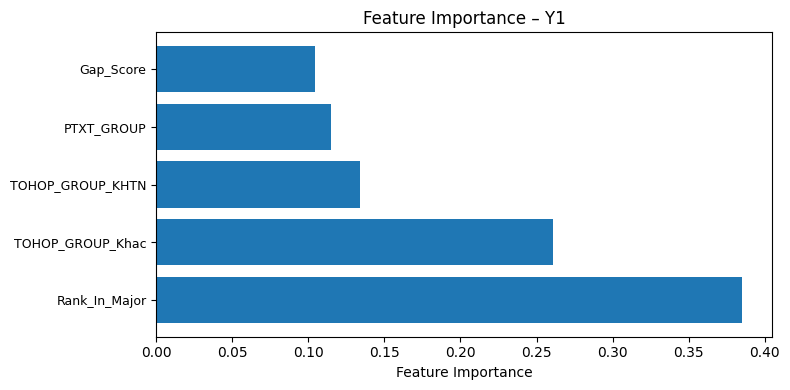

Đã lưu: /Users/apple/Documents/flow/last_dance/outputs/feature_importance_Y1.png


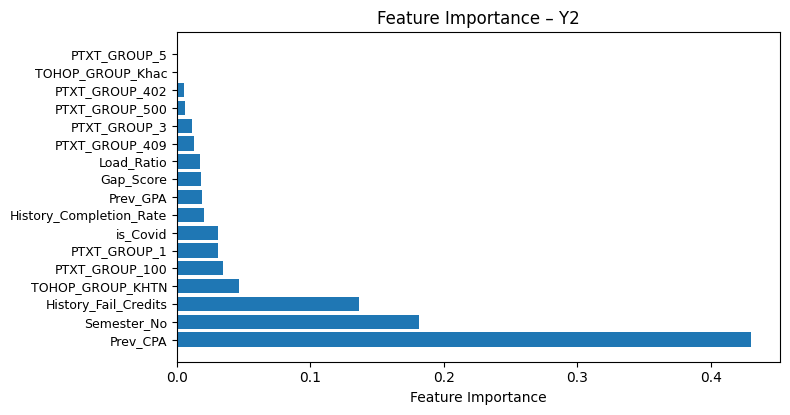

Đã lưu: /Users/apple/Documents/flow/last_dance/outputs/feature_importance_Y2.png


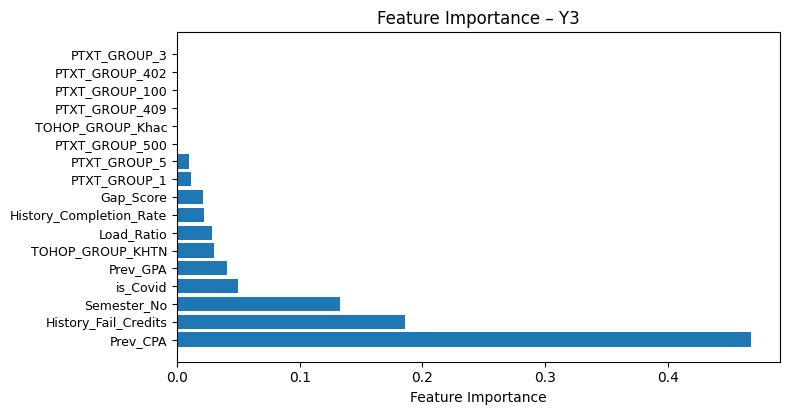

Đã lưu: /Users/apple/Documents/flow/last_dance/outputs/feature_importance_Y3.png


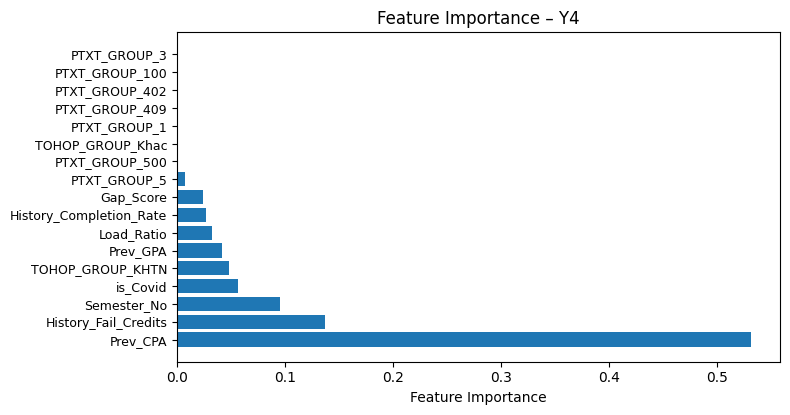

Đã lưu: /Users/apple/Documents/flow/last_dance/outputs/feature_importance_Y4.png


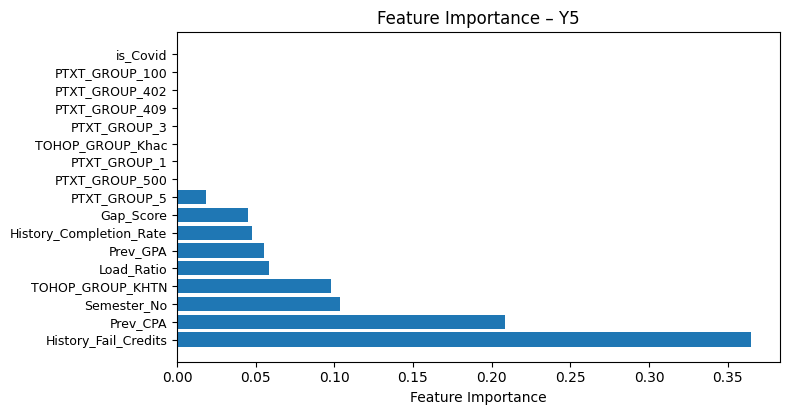

Đã lưu: /Users/apple/Documents/flow/last_dance/outputs/feature_importance_Y5.png


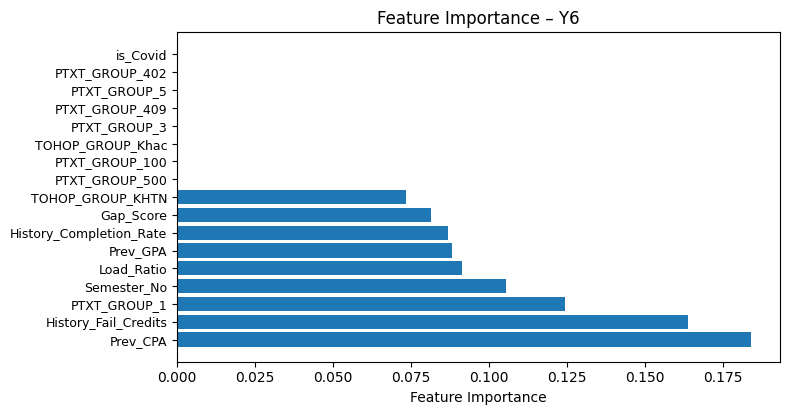

Đã lưu: /Users/apple/Documents/flow/last_dance/outputs/feature_importance_Y6.png


In [62]:
for key in models:
    prep = preprocessors[key]
    if hasattr(prep, "get_feature_names_out"):
        try:
            fnames_raw = prep.get_feature_names_out()
            fnames = [s.split("__", 1)[-1] for s in fnames_raw]
        except Exception:
            fnames = feature_names_per_group.get(key, [f"f{i}" for i in range(len(models[key].feature_importances_))])
    else:
        fnames = feature_names_per_group.get(key, [f"f{i}" for i in range(len(models[key].feature_importances_))])
    
    # Hiển thị feature importance cho model chung
    imp = models[key].feature_importances_
    if len(fnames) != len(imp):
        fnames = [f"f{i}" for i in range(len(imp))]
    order = np.argsort(imp)[::-1]
    fig, ax = plt.subplots(figsize=(8, max(4, len(order) * 0.25)))
    ax.barh(range(len(order)), imp[order], align="center")
    ax.set_yticks(range(len(order)))
    ax.set_yticklabels([fnames[i] for i in order], fontsize=9)
    ax.set_xlabel("Feature Importance")
    ax.set_title(f"Feature Importance – {key}")
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"feature_importance_{key}.png", dpi=100, bbox_inches="tight")
    plt.show()
    print("Đã lưu:", OUT_DIR / ("feature_importance_%s.png" % key))

## 6. SHAP (Shapley values – đóng góp từng feature)

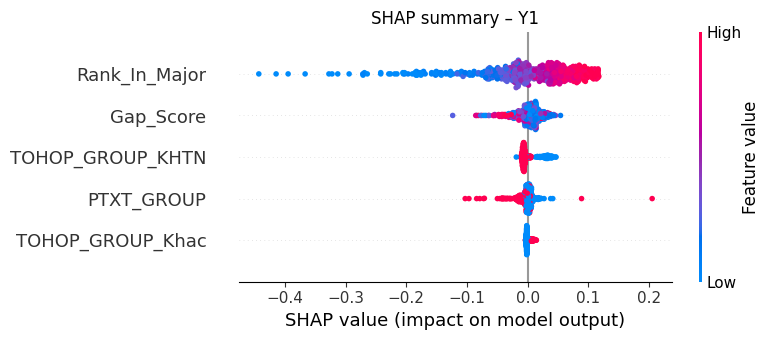

Đã lưu: /Users/apple/Documents/flow/last_dance/outputs/shap_summary_Y1.png


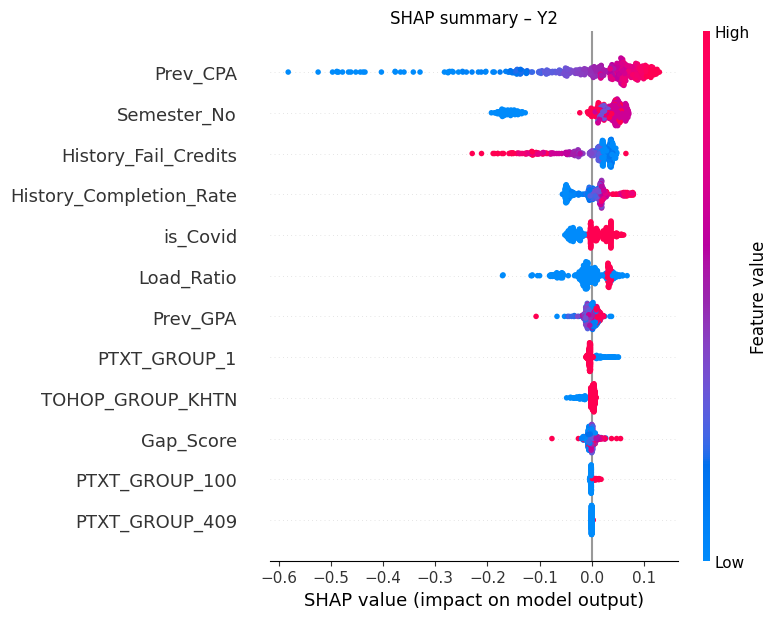

Đã lưu: /Users/apple/Documents/flow/last_dance/outputs/shap_summary_Y2.png


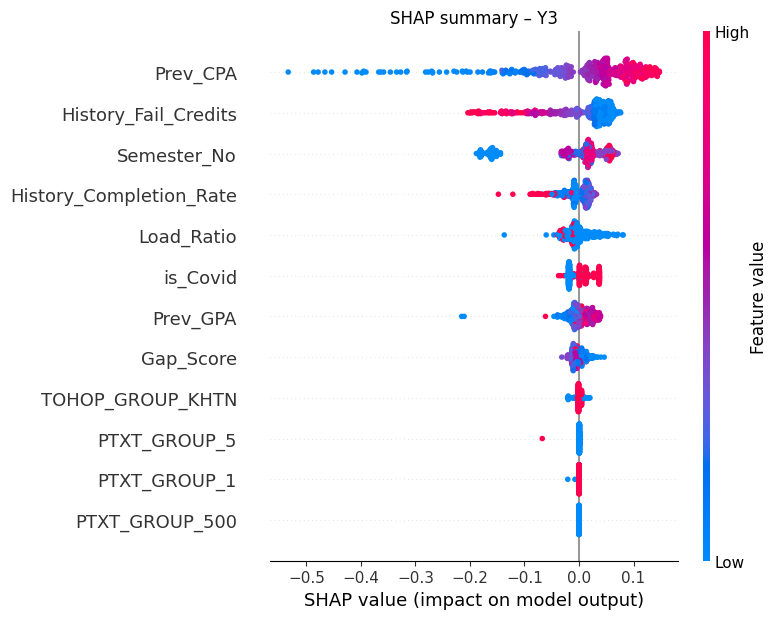

Đã lưu: /Users/apple/Documents/flow/last_dance/outputs/shap_summary_Y3.png


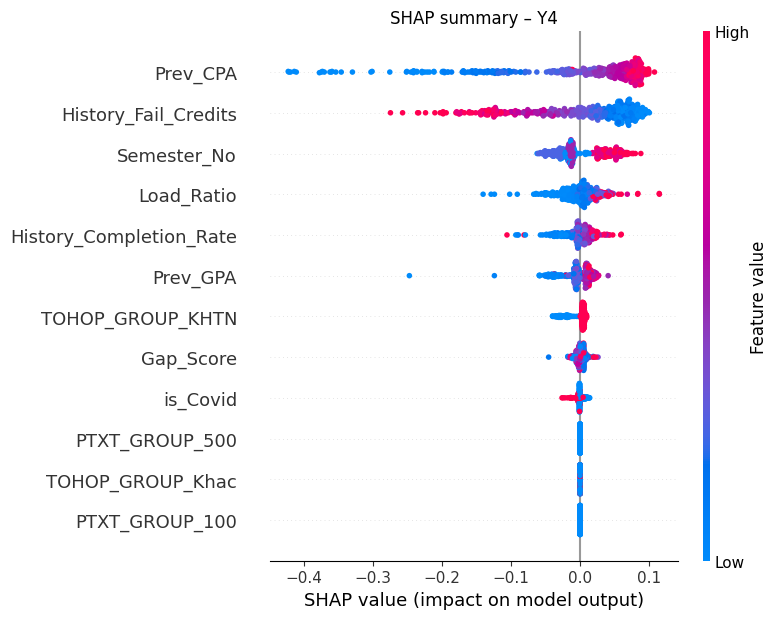

Đã lưu: /Users/apple/Documents/flow/last_dance/outputs/shap_summary_Y4.png


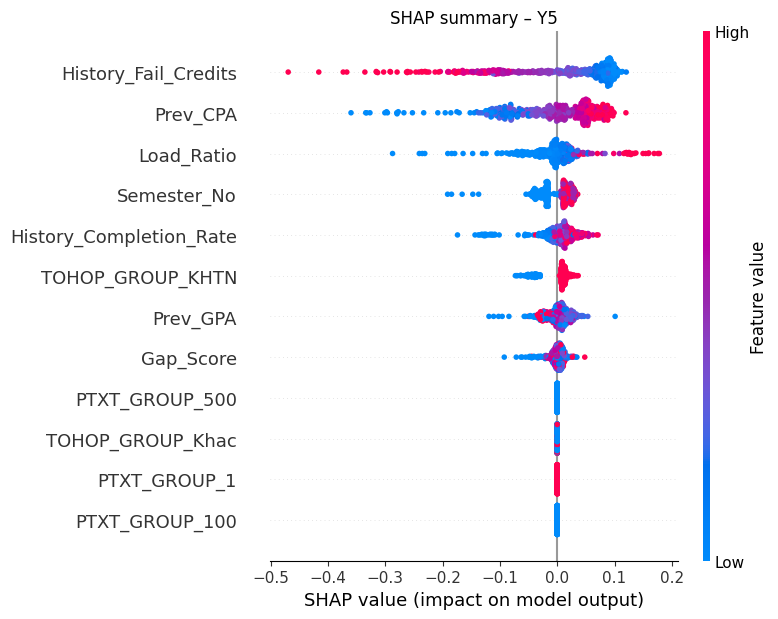

Đã lưu: /Users/apple/Documents/flow/last_dance/outputs/shap_summary_Y5.png


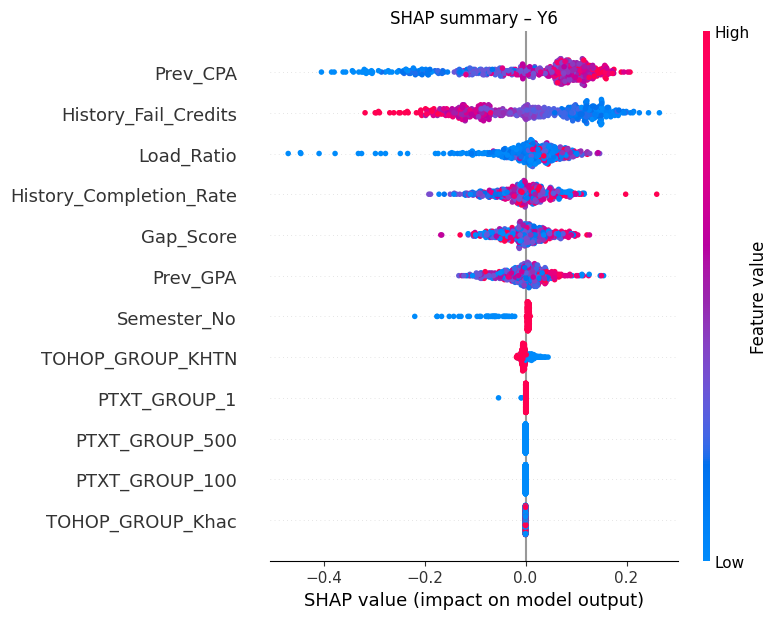

Đã lưu: /Users/apple/Documents/flow/last_dance/outputs/shap_summary_Y6.png


In [63]:
if shap is not None:
    for key in models:
        prep = preprocessors[key]
        X_raw = train_data[key]["X"].copy()
        num_cols_prep, cat_cols_prep = [], []
        for name, _, cols in prep.transformers_:
            if name == "num":
                num_cols_prep = list(cols)
            elif name == "cat":
                cat_cols_prep = list(cols)
        for c in X_raw.columns:
            if c in num_cols_prep:
                X_raw[c] = pd.to_numeric(X_raw[c], errors="coerce").fillna(0)
            elif c in cat_cols_prep:
                X_raw[c] = X_raw[c].astype(str).fillna("unknown")
            else:
                X_raw[c] = pd.to_numeric(X_raw[c], errors="coerce").fillna(0)
        X = prep.transform(X_raw)
        n_sample = min(500, len(X))
        idx = np.random.RandomState(SEED).choice(len(X), n_sample, replace=False)
        X_sample = X[idx]
        if hasattr(prep, "get_feature_names_out"):
            try:
                fnames_raw = prep.get_feature_names_out()
                if len(fnames_raw) == X.shape[1]:
                    fnames = [s.split("__", 1)[-1] for s in fnames_raw]
                else:
                    fnames = feature_names_per_group.get(key, [f"f{i}" for i in range(X.shape[1])])
            except Exception:
                fnames = feature_names_per_group.get(key, [f"f{i}" for i in range(X.shape[1])])
        else:
            fnames = feature_names_per_group.get(key, [f"f{i}" for i in range(X.shape[1])])
        # SHAP cho model chung
        explainer = shap.TreeExplainer(models[key], X_sample)
        shap_vals = explainer.shap_values(X_sample)
        shap.summary_plot(shap_vals, X_sample, feature_names=fnames, show=False, max_display=12)
        plt.title(f"SHAP summary – {key}")
        plt.tight_layout()
        plt.savefig(OUT_DIR / ("shap_summary_%s.png" % key), dpi=100, bbox_inches="tight")
        plt.show()
        print("Đã lưu:", OUT_DIR / ("shap_summary_%s.png" % key))
else:
    print("Cài shap để dùng: pip install shap")

## 8. Lưu mô hình và bảng kết quả

In [64]:
import joblib

for key in models:
    joblib.dump(models[key], OUT_DIR / f"xgb_model_{key}.joblib")
    joblib.dump(preprocessors[key], OUT_DIR / f"preprocessor_{key}.joblib")

if len(results_valid) > 0:
    df_valid.to_csv(OUT_DIR / "metrics_valid.csv", index=False)
df_train.to_csv(OUT_DIR / "metrics_train.csv", index=False)
print("Đã lưu mô hình và metrics vào", OUT_DIR)

Đã lưu mô hình và metrics vào /Users/apple/Documents/flow/last_dance/outputs
